In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
from torch.distributions.multivariate_normal import MultivariateNormal as MN
from torch.utils.data import DataLoader
import numpy as np
import math
import sys
import os
import time
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns


# settings for running on a specified Google Drive account.
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = "/content/gdrive/MyDrive/"

root = '.../SEGP/'

# Directory to import data from.
dataset_number = 1
data_path = gdrive_path + root + 'Data/Datasets/GP/Dataset{0}'.format(dataset_number)

# Setup directory to store models.
model_path = gdrive_path + root + 'Data/Models/SEGP/'

# Directory SEGP model is stored.
GP_path = gdrive_path + root + 'Code/SEGP/'

if GP_path in sys.path:
  print('directory already in path!')
else:
  sys.path.append(GP_path)

import SEGP

# Hardware settings.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print('Default tensor type is now cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print("Device in use is: ", device)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
directory already in path!
Device in use is:  cpu


In [ ]:

def get_dataloaders(data:torch.tensor, M:int, Q:int, N:int, m:int, batches:int,
                    bs:int, test_split:float):
  """
  Function for splitting data into train and test dataloaders.
  args:
              data: data to split with shape = (M, Q, N, m).
                 M: number of input signals.
                 Q: number of initial conditions.
                 N: number of discrete time points.
                 m: number of latent states.
           batches: number of batches.
                bs: batch size.
        test_split: ratio of batches to reserve for testing.
  returns:
      train_loader: dataloader with shape = (batches - N_test, bs, N, m).
       test_loader: dataloader with shape = (N_test, bs, N, m).
  """

  data = data.view(M*Q, N, m) # shape = (M * Q, N, m)

  # shuffle
  idx = torch.randperm(data.shape[0])
  data = data[idx]


  # reshape into shape = (batches, bs, N, m)
  if batches * bs != M * Q:
    print('M =', M)
    print('Q =', Q)
    raise Exception("batches * bs != M * Q!")
  else:
    data = data.view(batches, bs, N, m)


  # split into train and test sets.
  N_test = int(batches * test_split)
  if N_test < 1:
    raise Exception("No batches reserved for testing!")
  else:
    test_idx = np.random.randint(low=0, high=batches, size=N_test)
    train_idx = np.delete( np.arange(0, batches), test_idx)
    test_set = data[test_idx]
    train_set = data[train_idx]

  test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
  train_loader = DataLoader(train_set, batch_size=1, shuffle=False)

  return train_loader, test_loader


# import data
data_setup = np.load(data_path + '/data_setup.pkl', allow_pickle=True)
M = data_setup['M']
Q = data_setup['Q']
N = data_setup['N']
m = data_setup['m']

dYn = torch.from_numpy( np.load(data_path + '/dYn.npy') )

# setup data loaders.
batches = 10
bs = 1000
test_split = 0.1
train_loader, test_loader = get_dataloaders(dYn, M, Q, N, m, batches, bs, test_split)


## Training GP

In [ ]:
class MLL(nn.Module):
    """
    Class for computing the log marginal likelihood for a batch of data with shape (bs, N, m).
    """

    def __init__(self):
        super().__init__()
        self.pi = torch.tensor(math.pi)


    def Cholesky_inverse(self, covar):
        """
        Computes inverse of covar via Cholesky decomposition.
        args:
                covar: Covariance matrix with shape (m*N, m*N).
        returns:
                covar_inv: Inverse of covar.
        """
        L_inv = torch.inverse( torch.linalg.cholesky(covar) )
        covar_inv = torch.matmul( L_inv.t(), L_inv )

        return covar_inv



    def forward(self, obs:torch.tensor, mean:torch.tensor, covar:torch.tensor,
                covar_noise:torch.tensor):
        """
        Computes mll objective.
        args:
                  obs: Observed data (bs, N, m).
                 mean: SEGP mean function (N, m).
                covar: SEGP covariance matrix (m*N, m*N).
          covar_noise: Covariance matrix for the measurement noise (m*N, m*N).
        returns:
               mll_av: log marginal likelihood averaged over the batch.
        """

        bs, N, m = obs.shape

        total_covar = covar + covar_noise # shape = (m*N, m*N)

        self.register_buffer('eps', 1e-3 * torch.eye(m*N, m*N) )
        inv_tc = self.Cholesky_inverse(total_covar + self.eps) # shape = (m*N, m*N)

        obs = torch.transpose(obs, 1, 2).reshape(bs, m*N).unsqueeze(2) # shape = (bs, m*N, 1)
        mean = torch.transpose( mean.repeat(bs, 1, 1), 1, 2).reshape(bs, m*N).unsqueeze(2) # shape = (bs, m*N, 1)

        term1 = torch.bmm( inv_tc.repeat(bs, 1, 1), obs - mean ) # shape = (bs, m*N, 1)
        term1 = -0.5 * torch.bmm( torch.transpose(obs - mean, 1, 2), term1 )  # shape = (bs, 1, 1)
        term1 = term1.squeeze(2).squeeze(1) # shape = (bs)

        # add eps to avoid numerical issues computing term2 when covar_noise < 0.1.
        if torch.min(covar_noise) < 1e-1:
            self.register_buffer('eps', 1e-1 * torch.eye(m*N, m*N) )
            term2 = -0.5 * torch.log( torch.linalg.det(total_covar + self.eps) )
        else:
            term2 = -0.5 * torch.log( torch.linalg.det(total_covar) )

        term2 = term2.repeat(bs,1).squeeze(1) # shape = (bs)

        term3 = -0.5 * N * m * torch.log(2*self.pi)
        term3 = term3.repeat(bs,1).squeeze(1) # shape = (bs)


        mll = term1 + term2 + term3
        mll_av = mll.sum() / bs

        return mll_av




In [ ]:
def lr_scheduler(epoch:int, optimizer, decay:float, decay_epochs:list):
    """
    Decay learning rate by a factor decay for every epoch in decay_epochs.
    args:
               epoch: Current epoch of training loop.
           optimizer: Optimizer with parameters from previous epoch.
               decay: Scalar to multiply lr by.
        decay_epochs: List containing the epochs which the lr should be cut at.
    returns:
           optimizer: Same optimizer as before with updated lr.
    """

    if epoch in decay_epochs:
      for param_group in optimizer.param_groups:
          param_group['lr'] = decay*param_group['lr']

      print( 'New learning rate is: %.4f' % ( param_group['lr']) )

    return optimizer



def test_covar(covar, tol_sym=1e-3, tol_pos=1e-3):
    """
    Tests if covariance matrix is symmetric and positive definite.
    args:
          covar: Covariance matrix.
        tol_sym: tolerance for  symmetry check.
        tol_pos: tolerance for pos. def. check.
    returns:
        True if both conditions are met.
    """
    dim = covar.shape[0]
    eigs = torch.linalg.eigvals(covar)
    real_eigs = torch.real(eigs)

    sym_test = torch.allclose( covar, covar.t(), atol=tol_sym )
    eig_test = torch.all( torch.ge( real_eigs, -tol_pos*torch.ones(dim) ) )

    if not sym_test:
        raise Exception("Sorry, matrix is not symmetric!")
    if not eig_test.item():
        raise Exception("Sorry, matrix is not positive definite!")

    return True




In [ ]:
def train(dT:torch.tensor, tmax:float, mean_U:torch.tensor, mean_dU:torch.tensor, covar_noise:torch.tensor,
          train_loader, test_loader, max_epoch:int, model, optimizer, mll, decay:float, decay_epochs:list,
          model_dir:str, device, min_epoch=0, mean_train_losses=[], mean_test_losses=[]):
    """
    Training loop.
    args:
                    dT: Sampled time points to compute the prior mean and covariance matrix.
                  tmax: Maximum time point.
                mean_U: "Continuous" mean function of U used in GP integrals.
               mean_dU: Discretised mean function of U corresponding to dT.
           covar_noise: Covariance matrix for the measurement noise (m*N, m*N).
          train_loader: Dataloader for training set. Each batch has shape = (1, bs, N, m).
           test_loader: Dataloader for test set. Each batch has shape = (1, bs, N, m).
             max_epoch: Epoch which training will terminate at.
                 model: Instantiation of the chosen model.
             optimizer: Chosen optimizer.
                   mll: log marginal likelihood objective function.
                 decay: Scalar to multiply lr by.
          decay_epochs: List containing the epochs which the lr should be cut at.
             model_dir: Path to where models and data are stored.
                device: Hardware in use.
    optional:
             min_epoch: Epoch which training will start at.
     mean_train_losses: List containing training loss at each epoch from disrupted run.
      mean_test_losses: List containing test loss at each epoch from disrupted run.

    returns:
                model: Final version of the model.
    mean_train_losses: List containing updated training losses.
     mean_test_losses: List containing updated test losses.
    """

    if len(mean_train_losses) == 0:
        mean_train_losses = []

    if len(mean_test_losses) == 0:
        mean_test_losses = []

    for epoch in range(min_epoch, max_epoch):

        # training loop
        model.train()
        batch_losses = []

        for batch, y in enumerate(train_loader):

            y = y.to(device)
            optimizer.zero_grad()
            mean, covar = model(dT, tmax, mean_U, mean_dU)
            loss = -mll(y[0], mean, covar, covar_noise)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        mean_train_losses.append( np.mean(batch_losses) )

        optimizer = lr_scheduler(epoch, optimizer, decay, decay_epochs)

        # testing loop
        model.eval()
        batch_losses = []

        with torch.no_grad():
          for batch, y in enumerate(test_loader):
              y = y.to(device)
              mean, covar = model(dT, tmax, mean_U, mean_dU)
              loss = -mll(y[0], mean, covar, covar_noise)
              batch_losses.append(loss.item())

          mean_test_losses.append( np.mean(batch_losses) )

        print('Iter %d/%d - Train Loss: %.3f - Test Loss: %.3f'
          % (epoch + 1, max_epoch, mean_train_losses[epoch], mean_test_losses[epoch]))


        # save models
        model_path = model_dir + 'epoch{:03d}.pt'.format(epoch+1)
        torch.save(model.state_dict(), model_path)

        # save stats.
        stats_path = model_dir + 'stats.csv'
        stats = pd.DataFrame()
        stats["train loss"] = mean_train_losses
        stats["test loss"] = mean_test_losses
        stats.to_csv(stats_path, index=False)

        if device.type == 'cuda':
          torch.cuda.empty_cache()

    return model, mean_train_losses, mean_test_losses



In [ ]:
# Training loop.


model_name = 'SEGP'
exp_no = 3
model_dir = model_path + model_name + '/Exp_{:03d}/'.format(exp_no)

if os.path.isdir(model_dir):
    raise Exception("File already exists! Not overwriting.")
else:
    os.makedirs(model_dir)


# Import known parameters of data generation process.
n = data_setup['n']
p = data_setup['p']
lt = data_setup['lt']
tmax = data_setup['tmax']
mean_x0 = data_setup['mean_x0']
covar_x0 = data_setup['covar_x0']
covar_noise = data_setup['covar_noise']

# Import data.
dT = torch.from_numpy( np.load(data_path + '/dT.npy') )
mean_U = torch.from_numpy( np.load(data_path + '/mean_U.npy') )
mean_dU = torch.from_numpy( np.load(data_path + '/mean_dU.npy') )

# Instantiate model.
A_train = None
B_train = None
C_train = None
D_train = None

model = SEGP.SEGP(m, n, p, lt, mean_x0, covar_x0, A_train, B_train, C_train, D_train).to(device)

model_settings = {'m':m, 'n':n, 'p':p, 'lt':lt, 'mean_x0':mean_x0, 'covar_x0':covar_x0, 'A_train':A_train,
                  'B_train':B_train, 'C_train':C_train, 'D_train':D_train}


# Instantiate optimiser.
lr = 1e-2 # if covar_noise = 1e-1 -> lr = 1e-1. if covar_noise = 1e-2 -> lr = 1e-2. if covar_noise = 1e-3 -> lr = 1e-2.
wd = 1e-5 # weight decay
decay = 0.5 # scalar to multiply lr by at decay_epochs
decay_epochs = [70] # epochs to perform lr cut
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)  # Includes GaussianLikelihood parameters

# Instantiate loss - the marginal log likelihood.
mll = MLL()
min_epoch = 0
max_epoch = 50

train_settings = {'batches':batches, 'bs':bs, 'test_split':test_split, 'lr':lr, 'wd':wd,
                  'decay':decay, 'decay_epochs':decay_epochs, 'max_epoch':max_epoch}


with open(model_dir + 'model_settings.pkl', 'wb') as f:
    pickle.dump(model_settings, f)
    f.close()
with open(model_dir + 'train_settings.pkl', 'wb') as f:
    pickle.dump(train_settings, f)
    f.close()


 # Train model.
print( 'parameter count =', sum(p.numel() for p in model.parameters() if p.requires_grad) )
start_time = time.time()
print( "--- %s seconds ---" % (start_time) )


dT = dT.to(device)
mean_U = mean_U.to(device)
mean_dU = mean_dU.to(device)
covar_noise = covar_noise.to(device)


model, mean_train_losses, \
mean_test_losses = train(dT, tmax, mean_U, mean_dU, covar_noise, train_loader, test_loader, max_epoch,
                         model, optimizer, mll, decay, decay_epochs, model_dir, device)


exe_time = time.time() - start_time
print( "--- %s seconds ---" % (exe_time) )


train_settings = {'batches':batches, 'bs':bs, 'test_split':test_split, 'lr':lr, 'wd':wd,
                  'decay':decay, 'decay_epochs':decay_epochs, 'max_epoch':max_epoch,
                  'exe_time':exe_time}

with open(model_dir + 'train_settings.pkl', 'wb') as f:
    pickle.dump(train_settings, f)
    f.close()


parameter count = 68
--- 1736889753.8747852 seconds ---
Iter 1/50 - Train Loss: 34.262 - Test Loss: 30.073
Iter 2/50 - Train Loss: 27.709 - Test Loss: 26.079
Iter 3/50 - Train Loss: 25.395 - Test Loss: 24.228
Iter 4/50 - Train Loss: 23.472 - Test Loss: 22.432
Iter 5/50 - Train Loss: 21.707 - Test Loss: 20.672
Iter 6/50 - Train Loss: 19.972 - Test Loss: 18.993
Iter 7/50 - Train Loss: 18.301 - Test Loss: 17.335
Iter 8/50 - Train Loss: 16.635 - Test Loss: 15.649
Iter 9/50 - Train Loss: 14.931 - Test Loss: 13.932
Iter 10/50 - Train Loss: 13.246 - Test Loss: 12.292
Iter 11/50 - Train Loss: 11.624 - Test Loss: 10.666
Iter 12/50 - Train Loss: 10.032 - Test Loss: 9.089
Iter 13/50 - Train Loss: 8.440 - Test Loss: 7.461
Iter 14/50 - Train Loss: 6.844 - Test Loss: 5.960
Iter 15/50 - Train Loss: 5.652 - Test Loss: 5.323
Iter 16/50 - Train Loss: 5.347 - Test Loss: 5.170
Iter 17/50 - Train Loss: 5.155 - Test Loss: 5.061
Iter 18/50 - Train Loss: 5.076 - Test Loss: 4.967
Iter 19/50 - Train Loss: 4.988

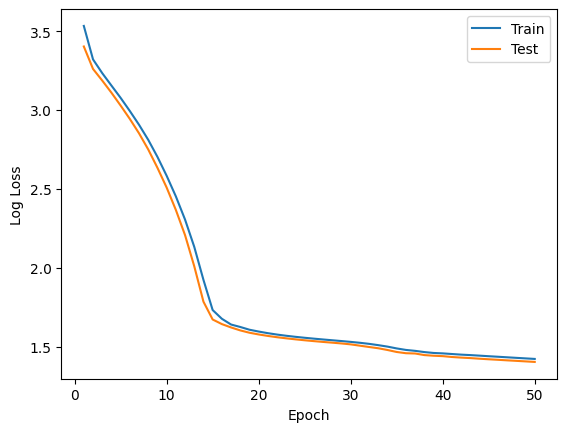

In [ ]:
# Plot loss
plt.plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_train_losses), label='Train')
plt.plot(torch.arange(1,max_epoch+1).cpu(), np.log(mean_test_losses), label='Test')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.savefig(model_dir + "Loss.png")
plt.show()

In [ ]:
# Instantiate ground truth model and compute mean, covar of learnt model.

A = data_setup['A']
B = data_setup['B']
C = data_setup['C']
D = data_setup['D']

model_gt = SEGP.SEGP(m, n, p, lt, mean_x0, covar_x0, A, B, C, D)
mean_gt, covar_gt = model_gt(dT, tmax, mean_U, mean_dU)

# model = SEGP.SEGP(m, n, p, lt, mean_x0, covar_x0, A, B, C, D) # use when passing in a model that hasn't been trained!
mean_lt, covar_lt = model(dT, tmax, mean_U, mean_dU)


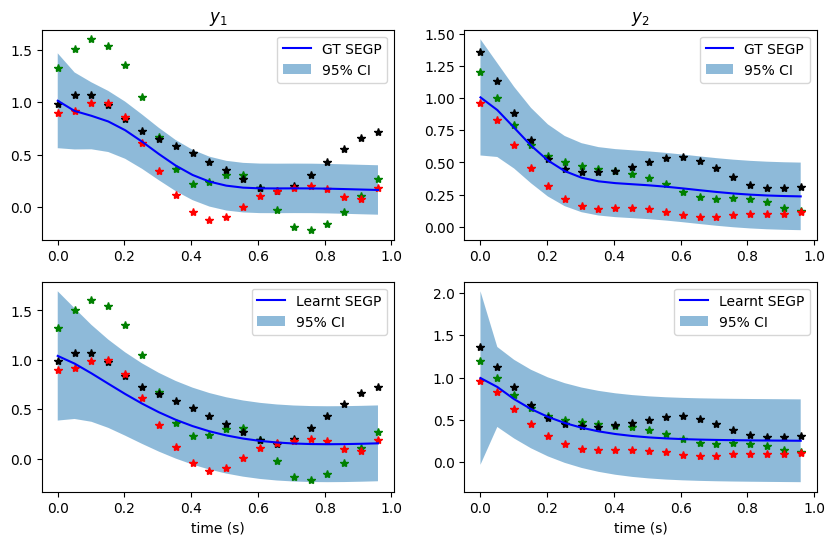

In [ ]:
# plot prior mean and uncertainty of SEGP against 3 trajectories from batch.

dY = torch.from_numpy( np.load(data_path + '/dY.npy') )

# 95% Confidence intervals
conf_gt = 2 * torch.sqrt( torch.diag(covar_gt) ).cpu().detach().numpy()
conf_lt = 2 * torch.sqrt( torch.diag(covar_lt) ).cpu().detach().numpy()
Nc = int( conf_gt.shape[0] / 2)

fy, (ygt_ax, ylt_ax) = plt.subplots(2, 2, figsize=(10, 6))

rand_idx = np.random.randint([M-1, Q-1], size=(3,2))

ygt_ax[0].plot(dT.cpu(), dY[rand_idx[0,0],rand_idx[0,1],:,0].cpu(), 'g*')
ygt_ax[0].plot(dT.cpu(), dY[rand_idx[1,0],rand_idx[1,1],:,0].cpu(), 'k*')
ygt_ax[0].plot(dT.cpu(), dY[rand_idx[2,0],rand_idx[2,1],:,0].cpu(), 'r*')

ygt_ax[1].plot(dT.cpu(), dY[rand_idx[0,0],rand_idx[0,1],:,1].cpu(), 'g*')
ygt_ax[1].plot(dT.cpu(), dY[rand_idx[1,0],rand_idx[1,1],:,1].cpu(), 'k*')
ygt_ax[1].plot(dT.cpu(), dY[rand_idx[2,0],rand_idx[2,1],:,1].cpu(), 'r*')

ygt_ax[0].plot(dT.cpu(), mean_gt[:,0].cpu().detach().numpy(), 'blue', label='GT SEGP')
ygt_ax[1].plot(dT.cpu(), mean_gt[:,1].cpu().detach().numpy(), 'blue', label='GT SEGP')

ygt_ax[0].fill_between(dT.cpu(), mean_gt[:,0].cpu().detach().numpy() - conf_gt[:Nc],
                   mean_gt[:,0].cpu().detach().numpy() + conf_gt[:Nc], alpha=0.5, label='95% CI')

ygt_ax[1].fill_between(dT.cpu(), mean_gt[:,1].cpu().detach().numpy() - conf_gt[Nc:],
                   mean_gt[:,1].cpu().detach().numpy() + conf_gt[Nc:], alpha=0.5, label='95% CI')



ylt_ax[0].plot(dT.cpu(), dY[rand_idx[0,0],rand_idx[0,1],:,0].cpu(), 'g*')
ylt_ax[0].plot(dT.cpu(), dY[rand_idx[1,0],rand_idx[1,1],:,0].cpu(), 'k*')
ylt_ax[0].plot(dT.cpu(), dY[rand_idx[2,0],rand_idx[2,1],:,0].cpu(), 'r*')

ylt_ax[1].plot(dT.cpu(), dY[rand_idx[0,0],rand_idx[0,1],:,1].cpu(), 'g*')
ylt_ax[1].plot(dT.cpu(), dY[rand_idx[1,0],rand_idx[1,1],:,1].cpu(), 'k*')
ylt_ax[1].plot(dT.cpu(), dY[rand_idx[2,0],rand_idx[2,1],:,1].cpu(), 'r*')

ylt_ax[0].plot(dT.cpu(), mean_lt[:,0].cpu().detach().numpy(), 'blue', label='Learnt SEGP')
ylt_ax[1].plot(dT.cpu(), mean_lt[:,1].cpu().detach().numpy(), 'blue', label='Learnt SEGP')

ylt_ax[0].fill_between(dT.cpu(), mean_lt[:,0].cpu().detach().numpy() - conf_lt[:Nc],
                   mean_lt[:,0].cpu().detach().numpy() + conf_lt[:Nc], alpha=0.5, label='95% CI')

ylt_ax[1].fill_between(dT.cpu(), mean_lt[:,1].cpu().detach().numpy() - conf_lt[Nc:],
                   mean_lt[:,1].cpu().detach().numpy() + conf_lt[Nc:], alpha=0.5, label='95% CI')

# fy.suptitle('Comparison Between Ground Truth SEGP and Learnt SEGP Prior')
ygt_ax[0].legend()
ygt_ax[1].legend()
ylt_ax[0].legend()
ylt_ax[1].legend()
ygt_ax[0].set_title('$y_{1}$')
ygt_ax[1].set_title('$y_{2}$')
ylt_ax[0].set_xlabel('time (s)')
ylt_ax[1].set_xlabel('time (s)')
plt.savefig(model_dir + "GT_versus_Learnt_SEGP.png")
plt.show()

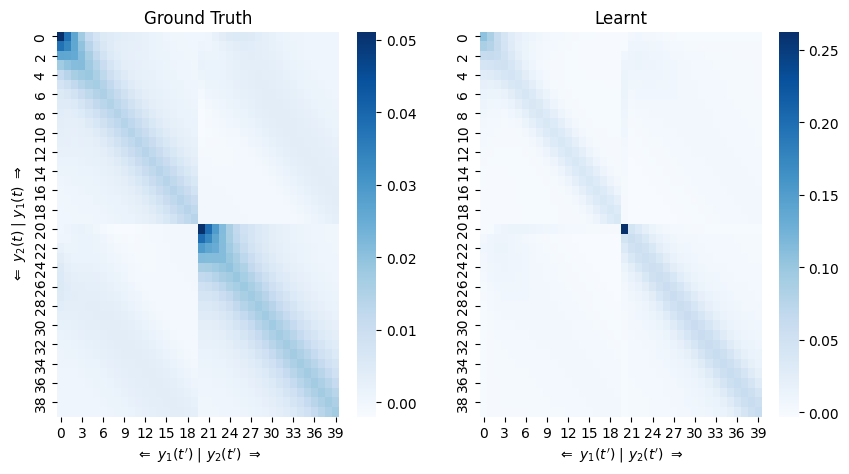

In [ ]:
# Plot ground truth against learnt stability enhanced covariance matrix.

fy, (covgt_ax, covlt_ax) = plt.subplots(1, 2, figsize=(10, 5))
ax0 = sns.heatmap(covar_gt.cpu().detach().numpy(), cmap='Blues', ax=covgt_ax)
ax1 = sns.heatmap(covar_lt.cpu().detach().numpy(), cmap='Blues', ax=covlt_ax)

# fy.suptitle('Comparison Between Ground Truth SEGP and Learnt SEGP Prior Covariance Matrix')
covgt_ax.set_title('Ground Truth')
covlt_ax.set_title('Learnt')
covgt_ax.set_ylabel("$\Leftarrow$ $y_{2}(t)$ | $y_{1}(t)$ $\Rightarrow$")
covgt_ax.set_xlabel("$\Leftarrow$ $y_{1}(t\')$ | $y_{2}(t\')$ $\Rightarrow$")
covlt_ax.set_xlabel("$\Leftarrow$ $y_{1}(t\')$ | $y_{2}(t\')$ $\Rightarrow$")
plt.savefig(model_dir + "GT_versus_Learnt_SEGPCov.png")
plt.show()


Comparison of Learnt SEGP Prior and Posterior Conditioned on 10 Noisy Observations of Traj. M=56, Q=28


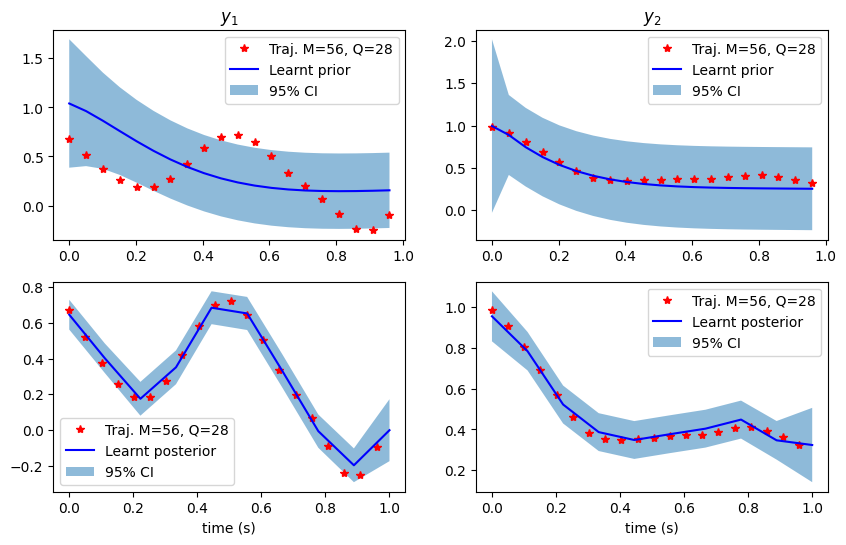

In [ ]:
# plot posterior versus prior against the relevant ground truth data.

# T = torch.from_numpy( np.load(data_path + '/T.npy') )
dYn = torch.from_numpy( np.load(data_path + '/dYn.npy') )

# Compute posterior of latent state (rand_M, rand_Q) at dT2.
Ts2 = 11
tmax2 = tmax
dT2 = T[torch.remainder(torch.arange(T.shape[0]), Ts2) == 0] # shape = (N2)
N2 = len(dT2)
mean_dU2 = mean_U[torch.remainder(torch.arange(mean_U.shape[0]), Ts2) == 0, :] # shape = (N2, p)

rand_idx = np.random.randint([M-1, Q-1], size=(1,2))
rand_M, rand_Q = rand_idx[0]
mean_post, covar_post = model.posterior(dT, dT2, tmax, tmax2, mean_U, mean_U, mean_dU, mean_dU2,
                                                 covar_noise.repeat(1, 1, 1), dYn[rand_M,rand_Q].repeat(1,1,1) ) # shapes = (1, N2, m) and (1, m*N2, m*N2)

mean_post = mean_post.squeeze(0) # shape = (N2, m)
covar_post = covar_post.squeeze(0) # shape = (m*N2, m*N2)

# 95% Confidence intervals
conf_post = 2 * torch.sqrt( torch.diag(covar_post) ).cpu().detach().numpy()


# Plot
fy, (ylt_ax, ypost_ax) = plt.subplots(2, 2, figsize=(10, 6))

string = 'Traj. M={0}, Q={1}'.format(rand_M, rand_Q)
ylt_ax[0].plot(dT.cpu(), dY[rand_M,rand_Q,:,0].cpu(), 'r*', label=string)
ylt_ax[1].plot(dT.cpu(), dY[rand_M,rand_Q,:,1].cpu(), 'r*', label=string)
ypost_ax[0].plot(dT.cpu(), dY[rand_M,rand_Q,:,0].cpu(), 'r*', label=string)
ypost_ax[1].plot(dT.cpu(), dY[rand_M,rand_Q,:,1].cpu(), 'r*', label=string)

ylt_ax[0].plot(dT.cpu(), mean_lt[:,0].cpu().detach().numpy(), 'blue', label='Learnt prior')
ylt_ax[1].plot(dT.cpu(), mean_lt[:,1].cpu().detach().numpy(), 'blue', label='Learnt prior')
ypost_ax[0].plot(dT2.cpu(), mean_post[:,0].cpu().detach().numpy(), 'blue', label='Learnt posterior')
ypost_ax[1].plot(dT2.cpu(), mean_post[:,1].cpu().detach().numpy(), 'blue', label='Learnt posterior')

ylt_ax[0].fill_between(dT.cpu(), mean_lt[:,0].cpu().detach().numpy() - conf_lt[:Nc],
                   mean_lt[:,0].cpu().detach().numpy() + conf_lt[:Nc], alpha=0.5, label='95% CI')

ylt_ax[1].fill_between(dT.cpu(), mean_lt[:,1].cpu().detach().numpy() - conf_lt[Nc:],
                   mean_lt[:,1].cpu().detach().numpy() + conf_lt[Nc:], alpha=0.5, label='95% CI')

ypost_ax[0].fill_between(dT2.cpu(), mean_post[:,0].cpu().detach().numpy() - conf_post[:N2],
                   mean_post[:,0].cpu().detach().numpy() + conf_post[:N2], alpha=0.5, label='95% CI')

ypost_ax[1].fill_between(dT2.cpu(), mean_post[:,1].cpu().detach().numpy() - conf_post[N2:],
                   mean_post[:,1].cpu().detach().numpy() + conf_post[N2:], alpha=0.5, label='95% CI')


string = 'Comparison of Learnt SEGP Prior and Posterior Conditioned on {0} Noisy Observations of Traj. M={1}, Q={2}'.format(N2, rand_M, rand_Q)
print(string)
# fy.suptitle(string)

ylt_ax[0].legend()
ylt_ax[1].legend()
ypost_ax[0].legend()
ypost_ax[1].legend()

ylt_ax[0].set_title('$y_{1}$')
ylt_ax[1].set_title('$y_{2}$')

ypost_ax[0].set_xlabel('time (s)')
ypost_ax[1].set_xlabel('time (s)')

plt.savefig(model_dir + "Posterior_versus_prior.png")
plt.show()


Posterior of Learnt SEGP Conditioned on 10 Noisy Observations of Traj. M=10, Q=56 Plotted Alognside Drawn Samples


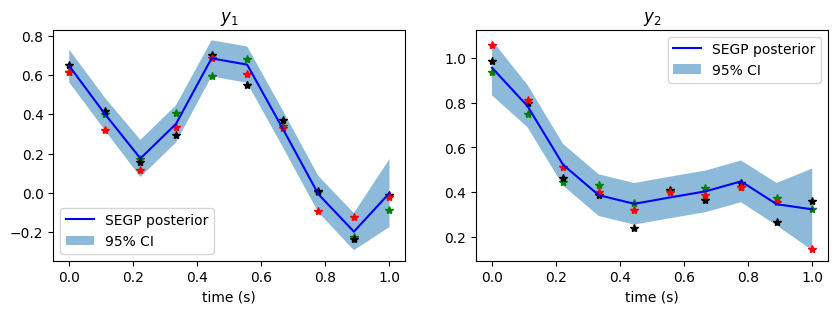

In [ ]:

# plot posterior mean and uncertainty of SEGP against samples from posterior.

# Draw samples from posterior.
n_samples = 10
samples = model.sample_posterior(n_samples) # shape = (bs, N2, m, n_samples)

samples = samples.squeeze(0) # shape = (N2, m, n_samples)

rand_idx = np.random.randint(n_samples, size=(3))
a, b, c = rand_idx

# Plot
fy, ypost_ax = plt.subplots(1, 2, figsize=(10, 3))

ypost_ax[0].plot(dT2.cpu(), samples[:,0,a].cpu().detach().numpy(), 'g*')
ypost_ax[0].plot(dT2.cpu(), samples[:,0,b].cpu().detach().numpy(), 'k*')
ypost_ax[0].plot(dT2.cpu(), samples[:,0,c].cpu().detach().numpy(), 'r*')

ypost_ax[1].plot(dT2.cpu(), samples[:,1,a].cpu().detach().numpy(), 'g*')
ypost_ax[1].plot(dT2.cpu(), samples[:,1,b].cpu().detach().numpy(), 'k*')
ypost_ax[1].plot(dT2.cpu(), samples[:,1,c].cpu().detach().numpy(), 'r*')


ypost_ax[0].plot(dT2.cpu(), mean_post[:,0].cpu().detach().numpy(), 'blue', label='SEGP posterior')
ypost_ax[1].plot(dT2.cpu(), mean_post[:,1].cpu().detach().numpy(), 'blue', label='SEGP posterior')

ypost_ax[0].fill_between(dT2.cpu(), mean_post[:,0].cpu().detach().numpy() - conf_post[:N2],
                   mean_post[:,0].cpu().detach().numpy() + conf_post[:N2], alpha=0.5, label='95% CI')

ypost_ax[1].fill_between(dT2.cpu(), mean_post[:,1].cpu().detach().numpy() - conf_post[N2:],
                   mean_post[:,1].cpu().detach().numpy() + conf_post[N2:], alpha=0.5, label='95% CI')


string = 'Posterior of Learnt SEGP Conditioned on {0} Noisy Observations of Traj. M={0}, Q={1} Plotted Alognside Drawn Samples'.format(N2, rand_M, rand_Q)
print(string)
# fy.suptitle(string)

ypost_ax[0].legend()
ypost_ax[1].legend()
ypost_ax[0].set_title('$y_{1}$')
ypost_ax[1].set_title('$y_{2}$')
ypost_ax[0].set_xlabel('time (s)')
ypost_ax[1].set_xlabel('time (s)')
plt.savefig(model_dir + "Learnt_SEGP_Posterior_and_Samples.png")
plt.show()
